In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [1]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-02 14-06-46.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 30  
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("2025-07-02 14-06-46_overlay.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_10.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary_10.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    # PyAV frame -> numpy array (RGB)
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1752252909.442728 23582296 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752252909.462105 23583087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752252909.470338 23583091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detected FPS from PyAV: 60.0


W0000 00:00:1752252925.452641 23583093 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


-------- Detection Report --------
Total frames: 8916
Frames with at least 1 hand detected: 3621
Detection rate: 40.61%


In [11]:
df = pd.read_csv("hand_landmarks_10.csv")

print("Shape:", df.shape)
df

Shape: (302694, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.000000,Left,0,NaN,NaN,NaN,0
1,0,0.000000,Left,1,NaN,NaN,NaN,0
2,0,0.000000,Left,2,NaN,NaN,NaN,0
3,0,0.000000,Left,3,NaN,NaN,NaN,0
4,0,0.000000,Left,4,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
302689,8915,148.583333,Right,16,NaN,NaN,NaN,0
302690,8915,148.583333,Right,17,NaN,NaN,NaN,0
302691,8915,148.583333,Right,18,NaN,NaN,NaN,0
302692,8915,148.583333,Right,19,NaN,NaN,NaN,0


In [14]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()

In [17]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,446,7.433,Left,1,0.603823,0.564204,0.548710,0.538586,0.535041,0.606678,...,0.060109,0.055614,0.040434,0.051114,0.040516,0.032216,0.031328,0.038334,0.035089,0.031658
1,447,7.450,Right,1,0.591841,0.560388,0.548648,0.538932,0.537040,0.605276,...,0.074878,0.070518,0.046174,0.057206,0.047974,0.040897,0.029658,0.037794,0.036080,0.033497
2,448,7.467,Left,1,0.607390,0.574451,0.564239,0.554326,0.548903,0.620556,...,0.039309,0.036250,0.028483,0.036445,0.033742,0.030532,0.022923,0.028771,0.029892,0.030034
3,449,7.483,Left,1,0.618930,0.583112,0.570095,0.557897,0.551916,0.628002,...,0.053775,0.052678,0.037388,0.048587,0.048067,0.046799,0.032420,0.040418,0.042422,0.043774
4,450,7.500,Left,1,0.616022,0.582507,0.570190,0.558525,0.552609,0.628702,...,0.044954,0.044917,0.035797,0.044324,0.043110,0.042178,0.035489,0.042152,0.043381,0.044564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3721,8335,138.917,Right,1,0.262162,0.335158,0.389980,0.429066,0.449966,0.325109,...,-0.105919,-0.091448,-0.067377,-0.084667,-0.075083,-0.062609,-0.046116,-0.054427,-0.048828,-0.040128
3722,8336,138.933,Right,1,0.260891,0.324678,0.371925,0.406435,0.425555,0.292481,...,-0.139282,-0.121634,-0.088545,-0.109449,-0.097865,-0.084750,-0.056072,-0.068429,-0.065352,-0.058968
3723,8337,138.950,Right,1,0.256067,0.324307,0.372453,0.406062,0.424116,0.291661,...,-0.144211,-0.131285,-0.085990,-0.108277,-0.102705,-0.094271,-0.052772,-0.065579,-0.064829,-0.060487
3724,8338,138.967,Right,1,0.251058,0.304949,0.355801,0.391547,0.401643,0.276188,...,-0.154906,-0.149930,-0.088058,-0.113317,-0.112980,-0.109520,-0.061287,-0.077481,-0.081096,-0.080908


In [21]:
df2 = pd.read_csv("hand_lable_10.csv")

print("Shape:", df.shape)
df2

Shape: (302694, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,10,2025-07-12 18:56:37.427,NaN,131.566,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,148.6,60.0,NaN,other,NaN,START,7.417,D:/Data Science/UOB/DS_project/Full Study/10/2...,445,NaN,NaN
1,10,2025-07-12 18:56:37.427,NaN,131.566,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,148.6,60.0,NaN,other,NaN,STOP,7.933,D:/Data Science/UOB/DS_project/Full Study/10/2...,476,NaN,NaN
2,10,2025-07-12 18:56:37.427,NaN,131.566,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,148.6,60.0,NaN,lift,NaN,START,8.300,D:/Data Science/UOB/DS_project/Full Study/10/2...,498,NaN,NaN
3,10,2025-07-12 18:56:37.427,NaN,131.566,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,148.6,60.0,NaN,lift,NaN,STOP,9.283,D:/Data Science/UOB/DS_project/Full Study/10/2...,557,NaN,NaN
4,10,2025-07-12 18:56:37.427,NaN,131.566,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,148.6,60.0,NaN,hold,NaN,START,9.300,D:/Data Science/UOB/DS_project/Full Study/10/2...,558,NaN,NaN
5,10,2025-07-12 18:56:37.427,NaN,131.566,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,148.6,60.0,NaN,hold,NaN,STOP,10.917,D:/Data Science/UOB/DS_project/Full Study/10/2...,655,NaN,NaN
6,10,2025-07-12 18:56:37.427,NaN,131.566,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,148.6,60.0,NaN,adjust,NaN,START,10.933,D:/Data Science/UOB/DS_project/Full Study/10/2...,656,NaN,NaN
7,10,2025-07-12 18:56:37.427,NaN,131.566,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,148.6,60.0,NaN,adjust,NaN,STOP,11.850,D:/Data Science/UOB/DS_project/Full Study/10/2...,711,NaN,NaN
8,10,2025-07-12 18:56:37.427,NaN,131.566,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,148.6,60.0,NaN,rotate,NaN,START,16.733,D:/Data Science/UOB/DS_project/Full Study/10/2...,1004,NaN,NaN
9,10,2025-07-12 18:56:37.427,NaN,131.566,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,148.6,60.0,NaN,rotate,NaN,STOP,27.133,D:/Data Science/UOB/DS_project/Full Study/10/2...,1628,NaN,NaN


In [23]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,other,7.417,7.933,445,476
1,lift,8.300,9.283,498,557
2,hold,9.300,10.917,558,655
3,adjust,10.933,11.850,656,711
4,rotate,16.733,27.133,1004,1628
5,other,37.533,37.850,2252,2271
6,rotate,51.733,58.100,3104,3486
7,place,58.233,58.883,3494,3533
8,rotate,63.017,69.817,3781,4189
9,place,78.900,79.617,4734,4777


In [26]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_17616/1143471531.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'other' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,446,7.433,Left,1,0.603823,0.564204,0.548710,0.538586,0.535041,0.606678,...,0.055614,0.040434,0.051114,0.040516,0.032216,0.031328,0.038334,0.035089,0.031658,other
1,447,7.450,Right,1,0.591841,0.560388,0.548648,0.538932,0.537040,0.605276,...,0.070518,0.046174,0.057206,0.047974,0.040897,0.029658,0.037794,0.036080,0.033497,other
2,448,7.467,Left,1,0.607390,0.574451,0.564239,0.554326,0.548903,0.620556,...,0.036250,0.028483,0.036445,0.033742,0.030532,0.022923,0.028771,0.029892,0.030034,other
3,449,7.483,Left,1,0.618930,0.583112,0.570095,0.557897,0.551916,0.628002,...,0.052678,0.037388,0.048587,0.048067,0.046799,0.032420,0.040418,0.042422,0.043774,other
4,450,7.500,Left,1,0.616022,0.582507,0.570190,0.558525,0.552609,0.628702,...,0.044917,0.035797,0.044324,0.043110,0.042178,0.035489,0.042152,0.043381,0.044564,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3721,8335,138.917,Right,1,0.262162,0.335158,0.389980,0.429066,0.449966,0.325109,...,-0.091448,-0.067377,-0.084667,-0.075083,-0.062609,-0.046116,-0.054427,-0.048828,-0.040128,rotate
3722,8336,138.933,Right,1,0.260891,0.324678,0.371925,0.406435,0.425555,0.292481,...,-0.121634,-0.088545,-0.109449,-0.097865,-0.084750,-0.056072,-0.068429,-0.065352,-0.058968,rotate
3723,8337,138.950,Right,1,0.256067,0.324307,0.372453,0.406062,0.424116,0.291661,...,-0.131285,-0.085990,-0.108277,-0.102705,-0.094271,-0.052772,-0.065579,-0.064829,-0.060487,rotate
3724,8338,138.967,Right,1,0.251058,0.304949,0.355801,0.391547,0.401643,0.276188,...,-0.149930,-0.088058,-0.113317,-0.112980,-0.109520,-0.061287,-0.077481,-0.081096,-0.080908,rotate


In [29]:
print(df_wide['behavior'].value_counts(dropna=False))

behavior
rotate    2293
NaN        938
other      199
place      123
hold        98
adjust      57
lift        18
Name: count, dtype: int64


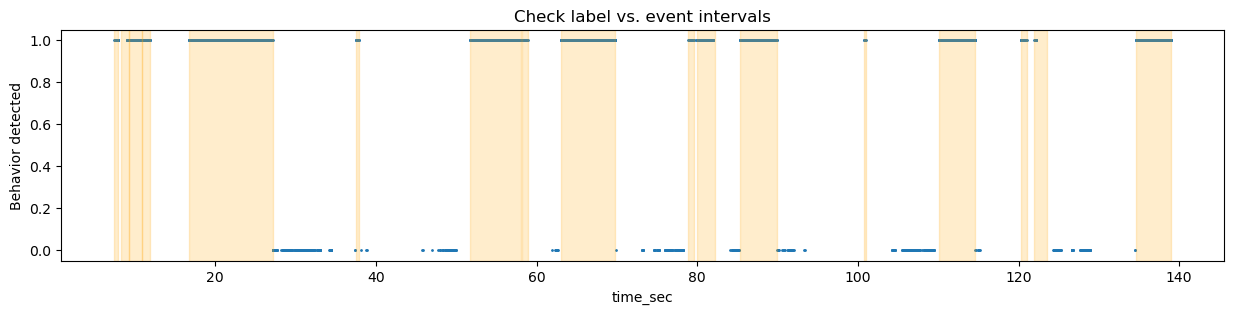

In [32]:
plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()

In [36]:
df_clean = df_wide.dropna(subset=['behavior'])

df_wide = df_clean

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,446,7.433,Left,1,0.603823,0.564204,0.548710,0.538586,0.535041,0.606678,...,0.055614,0.040434,0.051114,0.040516,0.032216,0.031328,0.038334,0.035089,0.031658,other
1,447,7.450,Right,1,0.591841,0.560388,0.548648,0.538932,0.537040,0.605276,...,0.070518,0.046174,0.057206,0.047974,0.040897,0.029658,0.037794,0.036080,0.033497,other
2,448,7.467,Left,1,0.607390,0.574451,0.564239,0.554326,0.548903,0.620556,...,0.036250,0.028483,0.036445,0.033742,0.030532,0.022923,0.028771,0.029892,0.030034,other
3,449,7.483,Left,1,0.618930,0.583112,0.570095,0.557897,0.551916,0.628002,...,0.052678,0.037388,0.048587,0.048067,0.046799,0.032420,0.040418,0.042422,0.043774,other
4,450,7.500,Left,1,0.616022,0.582507,0.570190,0.558525,0.552609,0.628702,...,0.044917,0.035797,0.044324,0.043110,0.042178,0.035489,0.042152,0.043381,0.044564,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3721,8335,138.917,Right,1,0.262162,0.335158,0.389980,0.429066,0.449966,0.325109,...,-0.091448,-0.067377,-0.084667,-0.075083,-0.062609,-0.046116,-0.054427,-0.048828,-0.040128,rotate
3722,8336,138.933,Right,1,0.260891,0.324678,0.371925,0.406435,0.425555,0.292481,...,-0.121634,-0.088545,-0.109449,-0.097865,-0.084750,-0.056072,-0.068429,-0.065352,-0.058968,rotate
3723,8337,138.950,Right,1,0.256067,0.324307,0.372453,0.406062,0.424116,0.291661,...,-0.131285,-0.085990,-0.108277,-0.102705,-0.094271,-0.052772,-0.065579,-0.064829,-0.060487,rotate
3724,8338,138.967,Right,1,0.251058,0.304949,0.355801,0.391547,0.401643,0.276188,...,-0.149930,-0.088058,-0.113317,-0.112980,-0.109520,-0.061287,-0.077481,-0.081096,-0.080908,rotate


In [61]:
df_wide['dataset_id'] = '10'

cols = df_wide.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide = df_wide[cols]

df_wide

,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,10,446,7.433,Left,1,0.603823,0.564204,0.548710,0.538586,0.535041,...,0.055614,0.040434,0.051114,0.040516,0.032216,0.031328,0.038334,0.035089,0.031658,other
1,10,447,7.450,Right,1,0.591841,0.560388,0.548648,0.538932,0.537040,...,0.070518,0.046174,0.057206,0.047974,0.040897,0.029658,0.037794,0.036080,0.033497,other
2,10,448,7.467,Left,1,0.607390,0.574451,0.564239,0.554326,0.548903,...,0.036250,0.028483,0.036445,0.033742,0.030532,0.022923,0.028771,0.029892,0.030034,other
3,10,449,7.483,Left,1,0.618930,0.583112,0.570095,0.557897,0.551916,...,0.052678,0.037388,0.048587,0.048067,0.046799,0.032420,0.040418,0.042422,0.043774,other
4,10,450,7.500,Left,1,0.616022,0.582507,0.570190,0.558525,0.552609,...,0.044917,0.035797,0.044324,0.043110,0.042178,0.035489,0.042152,0.043381,0.044564,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3721,10,8335,138.917,Right,1,0.262162,0.335158,0.389980,0.429066,0.449966,...,-0.091448,-0.067377,-0.084667,-0.075083,-0.062609,-0.046116,-0.054427,-0.048828,-0.040128,rotate
3722,10,8336,138.933,Right,1,0.260891,0.324678,0.371925,0.406435,0.425555,...,-0.121634,-0.088545,-0.109449,-0.097865,-0.084750,-0.056072,-0.068429,-0.065352,-0.058968,rotate
3723,10,8337,138.950,Right,1,0.256067,0.324307,0.372453,0.406062,0.424116,...,-0.131285,-0.085990,-0.108277,-0.102705,-0.094271,-0.052772,-0.065579,-0.064829,-0.060487,rotate
3724,10,8338,138.967,Right,1,0.251058,0.304949,0.355801,0.391547,0.401643,...,-0.149930,-0.088058,-0.113317,-0.112980,-0.109520,-0.061287,-0.077481,-0.081096,-0.080908,rotate


In [67]:
behavior_counts = df_wide['behavior'].value_counts()

print(behavior_counts)

behavior
rotate    2293
other      199
place      123
hold        98
adjust      57
lift        18
Name: count, dtype: int64


In [63]:
df_wide.to_csv("handlandmark_wide_10.csv", index=False)